## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.LeakyReLU(),
            nn.Linear(512, num_classes),
            nn.LogSoftmax()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
         LeakyReLU-3                  [-1, 512]               0
            Linear-4                   [-1, 10]           5,130
        LogSoftmax-5                   [-1, 10]               0
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.55
Estimated Total Size (MB): 1.57
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Your experiments come here:

In [9]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-3)
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here

In [10]:
def plot_losses(losses, labels, figsize=(18, 8)):
  clear_output(wait=True)
  plt.figure(figsize=figsize)
  for loss, label in zip(losses, labels):
    plt.plot(loss, label=label)
  plt.xlabel("#iteration")
  plt.ylabel("loss")
  plt.legend()
  plt.show()

In [11]:
def train(n_epoch, model=model, opt=opt, loss_func=loss_func):
  loss_history = []
  for i in range(n_epoch):
    epoch_loss = 0
    for x_batch, y_batch in train_loader:
        opt.zero_grad()
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        predictions = model.forward(x_batch)
        loss = loss_func(predictions, y_batch)
        loss.backward()
        epoch_loss += loss.item()
        opt.step()

    loss_history.append(epoch_loss / len(train_loader))

  return loss_history

In [12]:
def get_accuracy(model=model, opt=opt, loss_func=loss_func):
  correct = 0
  count = 0

  for x_batch, y_batch in test_loader:
      x_batch = x_batch.to(device)
      
      predictions = model(x_batch)
      correct += (predictions.max(1)[1].detach().cpu().numpy() == y_batch.numpy()).sum()
      count += y_batch.size(0)
  
  return correct / count

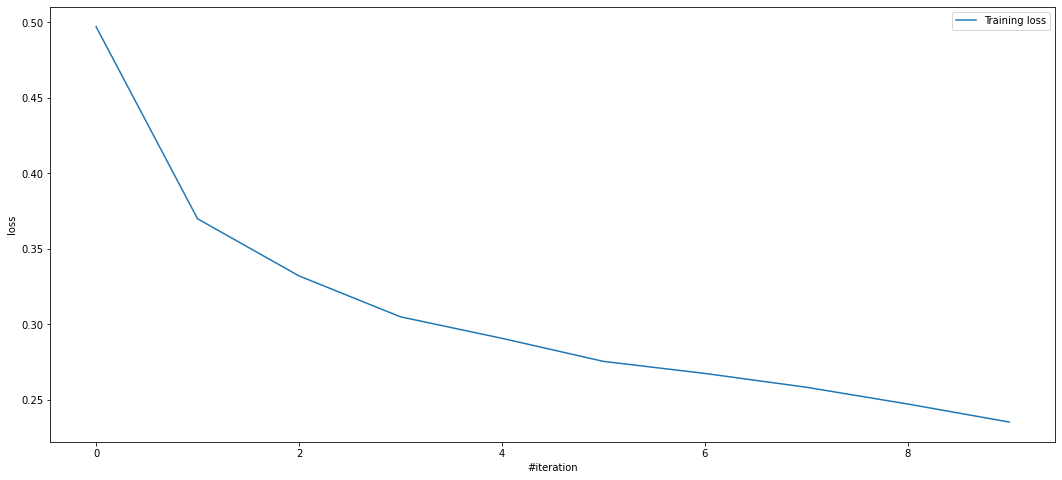

CPU times: user 18.2 s, sys: 3.67 s, total: 21.9 s
Wall time: 1min 15s


In [13]:
%%time
losses = train(10)
plot_losses([losses], ['Training loss'])

In [14]:
print(f"Accuracy = {get_accuracy()}")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy = 0.8757


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), 
            
            nn.Linear(input_shape, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

In [ ]:
model = OverfittingNeuralNetwork().to(device)
opt = # YOUR CODE HERE
loss_func = # YOUR CODE HERE

# Your experiments, come here

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

In [ ]:
model = FixedNeuralNetwork().to(device)
opt = # YOUR CODE HERE
loss_func = # YOUR CODE HERE

# Your experiments, come here

### Conclusions:
_Write down small report with your conclusions and your ideas._